In [1]:
import numpy as np
def dde_solve(ddes, state_vars, delayed_vars, histories, tmax, timestep, **options):
    """Numerically integrates a system of DDEs using 4th-order Runge-Kutta

    A delay differential equation is a (system of) equation(s) of the form 
        X'(t) = f(X, Y, ... , X_tau1, X_tau2, ... , Y_tau1, ... )

        Y'(t) = g(X, Y, ... , X_tau1, X_tau2, ... , Y_tau1, ... )

    where on the right hand side X denotes X(t) and each X_tau denotes 
    X(t - tau) for some constant delay tau, and likewise for Y and Y_tau. 

    INPUTS:

    - ``ddes`` - A list/tuple of Sagemath symbolic expressions that are the 
      right-hand-side of each delay differential equation

    - ``state_vars`` - A list/tuple of the state variables to use

    - ``delayed_vars`` - A dictionary whose keys are the symbolic variables 
      that represent delayed variables in the DDE expressions, and whose 
      values are 2-tuples consisting of the corresponding state variable and 
      the length of the delay. For example, for the delayed Lotka-Volterra 
      system 
      ::
        N'(t) = N(t) - N(t) P(t)
        P'(t) = N(t - 5) P(t) - P(t)
      the ``ddes`` argument might be written as 
        (N - N * P, Ntau * P - P)
      in which case the ``delayed_vars`` argument would be 
        {Ntau: (N, 5)}
      You can read this as ``Ntau represents N delayed by 5``. Note this 
      means that before calling this function, all three of `N`, `P`, 
      and `Ntau` should have been declared as symbolic variables: 
        var("N, P, Ntau")

    - ``histories`` - A list/tuple of functions or Sagemath expressions giving 
      the history of each state variable, as a function of ``t`` (time)

    - ``tmax`` - Integrate from t = 0 to this time

    - ``timestep`` - The size of each time step (the smaller, the more 
      accurate)

    OPTIONS:

    - ``t_var`` - The variable to use for time in the history functions. 
      Defaults to ``t``. 

    - ``starting_t`` - The starting value of t to use. Defaults to 0. 

    OUTPUT:

    An array with one column for the t values, and one column for each of the 
    state variables, in the order they were specified. The output array will 
    of course have one row for each time step, from t = 0 (or t = 
    ``starting_t`` if specified) to t = ``tmax``. 

    Note that having the t-values included in the first column of the output 
    is for convenience, so that one can plot time series, trajectories, etc, 
    without having to use ``zip`` or ``numpy.insert``. See the examples below. 

    EXAMPLES:

    A version of Mackey-Glass, using a constant 0 history::

        var("X, X_t")
        solution = dde_solve(1 - X * X_t^5 / (1 + X_t^5), X, {X_t: (X, 8)}, history=0, tmax=400, timestep=0.1)
        list_plot(solution, plotjoined=True)

    The same, but with an oscillating history function, giving weird 
    transients that give way to a periodic steady state::

        var("t, X, X_tau")
        eq = 1 - X * X_tau^5 / (1 + X_tau^5)
        solution = dde_solve(eq, X, {X_tau: (X, 8)}, 5*cos(t), 400, 0.1)
        list_plot(solution, plotjoined=True)

    HPG model, replacing the P with a delayed H::

        var("H, G, H_tau")
        ddes = (
            1 / (1 + G^n) - 0.2*H, 
            H_tau - 0.2*G, 
        )
        delayed_vars = {H_tau: (H, 0.7)}
        solution = dde_solve(ddes, (H, G), delayed_vars, (1, 1), 100, 0.01)
        list_plot(solution[:,(0,1)], plotjoined=True) # Plot the H time series
        list_plot(solution[:,(0,2)], plotjoined=True) # Plot the G time series
        list_plot(solution[:,(1,2)], plotjoined=True) # Plot a trajectory
    """

    # Check validity of delays. 
    if any([delay < 0 for dvar, delay in delayed_vars.values()]):
        raise ValueError("This function will not work with negative delays. "
            "Consider consulting a fortune teller instead.")

    # Deal with extra options
    starting_t = options.get("starting_t", 0)
    t_var = options.get("t_var", "t")

    # If they gave a single DDE, convert it to a system
    if isinstance(state_vars, sage.symbolic.expression.Expression):
        ddes = [ddes]
        state_vars = [state_vars]
        histories = [histories]

    # Set up for history lookups
    delayed_vars = delayed_vars.items()
    ddes = [dde.subs({dv: sv for dv, (sv, delay) in delayed_vars if delay == 0}) for dde in ddes]
    delayed_vars = [(dv, (sv, delay)) for dv, (sv, delay) in delayed_vars if delay != 0]
    all_vars = set().union(*[dde.variables() for dde in ddes])
    actual_delays = set([delay for dv, (sv, delay) in delayed_vars if dv in all_vars])
    delays = []
    all_vars = list(state_vars)
    for this_delay in sorted(actual_delays):
        delays.append((this_delay, [state_vars.index(sv) for dv, (sv, delay) in delayed_vars if delay == this_delay]))
        all_vars.extend([dv for dv, (sv, delay) in delayed_vars if delay == this_delay])
    ddes = [fast_float(dde, *all_vars) for dde in ddes]
    histories = [fast_float(history, t_var) for history in histories]
    num_state_vars = len(state_vars)

    # Adjust the timestep if necessary
    if delays:
        timestepcorrectionfactor = ceil(timestep / delays[0][0] * 2)
    else:
        timestepcorrectionfactor = 1
    timestep /= timestepcorrectionfactor

    # Initialize the solver
    t = starting_t
    state = np.array([history(t) for history in histories])
    t_values = [t]
    solution = [state]
    var_values = np.zeros(len(all_vars), dtype=float)

    # The function that performs a complete history lookup
    def lookup(t):
        """Does a history lookup at each delay from t, stores result in var_values[num_state_vars:]"""
        i = num_state_vars
        for delay, indices in delays:
            next_i = i + len(indices)
            t0 = t - delay
            if t0 <= starting_t:
                var_values[i:next_i] = [histories[j](t0) for j in indices]
            else:
                r = t0 / timestep
                n = floor(r) # Sagemath correctly returns an *int* here, not a float!
                r -= n
                var_values[i:next_i] = (solution[n]*(1 - r) + solution[n + 1]*r)[indices]
            i = next_i

    # Set up for the first iteration...
    lookup(t)
    # ...and iterate!
    while t < tmax:
        # Compute k1. Note history lookup has already been done. 
        var_values[:num_state_vars] = state
        k1 = np.array([dde(*var_values) for dde in ddes])
        # Compute k2. 
        var_values[:num_state_vars] += timestep/2 * k1
        lookup(t + timestep/2)
        k2 = np.array([dde(*var_values) for dde in ddes])
        # Compute k3. Note history lookup has already been done. 
        var_values[:num_state_vars] = state + timestep/2 * k2
        k3 = np.array([dde(*var_values) for dde in ddes])
        # Compute k4. 
        var_values[:num_state_vars] = state + timestep * k3
        lookup(t + timestep)
        k4 = np.array([dde(*var_values) for dde in ddes])
        # Finally, compute the RK4 weighted average. 
        t += timestep
        state = state + (k1 + 2*k2 + 2*k3 + k4)/6 * timestep # Do not use += here, to force a copy!
        t_values.append(t)
        solution.append(state)
    solution = np.array(solution)
    return np.insert(solution, 0, t_values, axis=1)[::timestepcorrectionfactor]


**The CO$_2$ ventilation model (Mackey–Glass)**

$X(t) = $ the concentration of CO$_2$ in the blood *at the lung*

$$ X'(t) = 6 - 16 X(t) \cdot \frac{X(t - \tau)^n}{1 + X(t - \tau)^n} $$

In [2]:
@interact(n=slider(1, 10, 1, default=2, label=r"$n$ (steepness)"), 
          delay=slider(0, 0.9, 0.02, default=0.1, label=r"$\tau$ (delay)"), 
          tmax=slider([4, 10, 20, 50], label=r"$t_{max}$"))
def co2_ventilation_sigmoid(n, delay, tmax):
    X, X_tau = var("X, X_tau")
    l = 6
    v_max = 80
    a = 0.2
    history = 4
    timestep = 0.01
    sigmoid = v_max * X_tau^n/(1 + X_tau^n)
    diffeq = l - sigmoid * a*X
    label = r"$X'(t) = %d - %d X(t) \cdot \frac{X(t - %.02f)^{%d}}{1 + X(t - %.02f)^{%d}}$"
    label = label % (l, a*v_max, delay, n, delay, n)

    solution = dde_solve(diffeq, X, {X_tau: (X, delay)}, history, tmax, timestep)
    p1 = list_plot(solution, plotjoined=True, ymin=0, ymax=6, axes_labels=("$t$", "$X$"))
    p1 += text(label, (tmax/2, 5), color="black", fontsize=20, aspect_ratio=tmax/8)

    p2 = plot(sigmoid, (X_tau, 0, 3), thickness=2, 
              ymax=1.5*v_max, axes_labels=(r"$X$", ""), title="Breathing rate")
    p2 += line(((0, v_max), (3, v_max)), color="red", linestyle="dashed", figsize=2)
    both = multi_graphics([(p1, (0, 0, 0.65, 1)), 
                           (p2, (0.75, 0.6, 0.25, 0.2))])
    both.show(figsize=9)


Interactive function <function co2_ventilation_sigmoid at 0x7fc069d78af0> with 3 widgets
  n: TransformIntSlid…

Hopf bifurcation diagram for the CO$_2$ ventilation model

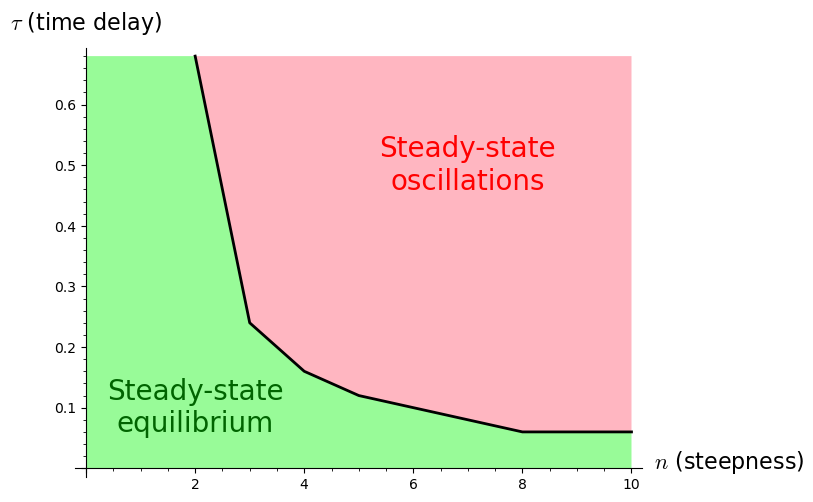

In [3]:
min_delay_for_oscillations = {
    2: 0.68, 
    3: 0.24, 
    4: 0.16, 
    5: 0.12, 
    6: 0.10, 
    7: 0.08, 
    8: 0.06, 
    9: 0.06, 
    10: 0.06, 
}

xmax = max(min_delay_for_oscillations.keys())
ymax = max(min_delay_for_oscillations.values())
vertices = sorted(list(min_delay_for_oscillations.items()))

p = list_plot(vertices, plotjoined=True, thickness=2, color="black")
p += polygon([(xmax,0), (0,0), (0,ymax)] + vertices, color="palegreen")
p += polygon([(xmax,ymax)] + vertices, color="lightpink")
p += text("Steady-state\noscillations", (7, 0.5), color="red", fontsize=20)
p += text("Steady-state\nequilibrium", (2, 0.1), color="darkgreen", fontsize=20)
p.show(aspect_ratio="auto", axes_labels=("$n$ (steepness)", "$\\tau$ (time delay)"), figsize=7.5)


**Recall the HPG model:**

$$ \begin{cases}
    H'(t) = \frac{1}{1 + G(t)^n} - 0.2H(t) \\
    P'(t) = H(t) - 0.2P(t) \\
    G'(t) = P(t) - 0.2G(t)
\end{cases} $$


In [4]:
@interact(n=slider(2, 20, 1, default=2, label="$n$ (steepness)"))
def hpg_interact(n):
    tmax = 150
    ymax = 7
    vectorfield(H, P, G) = (1 / (1 + G^n) - 0.2*H, H - 0.2*P, P - 0.2*G)
    t_range = srange(0, tmax, 0.01)
    initial_state = (0.5, 1, 1)
    solution = desolve_odeint(vectorfield, initial_state, t_range, [H, P, G])
    solution = np.insert(solution, 0, t_range, axis=1)

    p1 = list_plot(solution[:,(0,1)], plotjoined=True, color="gold", legend_label="$H$")
    p1 += list_plot(solution[:,(0,2)], plotjoined=True, color="blue", legend_label="$P$")
    p1 += list_plot(solution[:,(0,3)], plotjoined=True, color="red", legend_label="$G$", ymin=0, ymax=ymax, 
                    axes_labels=("$t$", "Hormone\nconcentrations"), aspect_ratio=2/3*tmax/ymax)

    p2 = plot(1 / (1 + G^n), (G, 0, 3), thickness=2, ymin=0, ymax=1.3)
    p2 += line(((0, 1), (3, 1)), color="red", linestyle="dashed")
    p2 += text(r"$\frac{1}{1 + G^{%d}}$" % n, (2.2, 0.5), color="black", fontsize=20, 
               axes_labels=(r"$G$", ""), title="Production rate of GnRH")
    both = multi_graphics([(p1, (0, 0, 0.65, 1)), 
                           (p2, (0.75, 0.6, 0.25, 0.2))])
    both.show(figsize=9)


Interactive function <function hpg_interact at 0x7fc06666ec10> with 1 widget
  n: TransformIntSlider(value=2, …

**The HPG model, without the “P”:**

$$ \begin{cases}
    H'(t) = \frac{1}{1 + G(t)^n} - 0.2H(t) \\
    G'(t) = H(t) - 0.2G(t)
\end{cases} $$

This should have less “implicit time delay”, because there are only two variables in the feedback loop. 

In [1]:
@interact(n=slider(2, 40, 1, default=12, label="$n$ (steepness)"))
def hg_interact(n):
    tmax = 150
    ymax = 7
    vectorfield(H, G) = (1 / (1 + G^n) - 0.2*H, H - 0.2*G)
    t_range = srange(0, tmax, 0.01)
    initial_state = (0.5, 1)
    solution = desolve_odeint(vectorfield, initial_state, t_range, [H, G])
    solution = np.insert(solution, 0, t_range, axis=1)

    p1 = list_plot(solution[:,(0,1)], plotjoined=True, color="gold", legend_label="$H$")
    p1 += list_plot(solution[:,(0,2)], plotjoined=True, color="red", legend_label="$G$", ymin=0, ymax=ymax, 
                    axes_labels=("$t$", "Hormone\nconcentrations"), aspect_ratio=2/3*tmax/ymax)

    p2 = plot(1 / (1 + G^n), (G, 0, 3), thickness=2, ymin=0, ymax=1.3)
    p2 += line(((0, 1), (3, 1)), color="red", linestyle="dashed")
    p2 += text(r"$\frac{1}{1 + G^{%d}}$" % n, (2.2, 0.5), color="black", fontsize=20, 
               axes_labels=(r"$G$", ""), title="Production rate of GnRH")
    both = multi_graphics([(p1, (0, 0, 0.65, 1)), 
                           (p2, (0.75, 0.6, 0.25, 0.2))])
    both.show(figsize=9)


Interactive function <function hg_interact at 0x7f4ffd6d71f0> with 1 widget
  n: TransformIntSlider(value=12, …

**The HPG model, without the “P”, but with an explicit time delay:**

To make up for the extra (implicit) delay that should be there (from the $H$ signal having to pass through $P$), we set an explicit time delay on the $H$ term appearing in the $G'$ equation. 

$$ \begin{cases}
    H'(t) = \frac{1}{1 + G(t)^n} - 0.2H(t) \\
    G'(t) = H(t - \tau) - 0.2G(t)
\end{cases} $$


In [6]:
@interact(n=slider(2, 40, 1, default=12, label=r"$n$ (steepness)"), 
          tau=slider(0, 4.5, 0.1, default=0, label=r"$\tau$ (delay)"), 
          tmax=slider([60, 120, 200, 300], default=60, label=r"$t_{max}$"))
def hg_delay(n, tau, tmax):
    ymax = 3
    vectorfield(H, G, H_tau) = ( 1 / (1 + G^n) - 0.2*H, H_tau - 0.2*G )
    delayed_vars = {H_tau: (H, tau)}
    histories = (0.5, 1)
    solution = dde_solve(vectorfield, (H, G), delayed_vars, histories, tmax, 0.01)

    p1 = list_plot(solution[:,(0,1)], plotjoined=True, color="gold", legend_label="$H$")
    p1 += list_plot(solution[:,(0,2)], plotjoined=True, color="red", legend_label="$G$", ymin=0, ymax=ymax, 
                    axes_labels=("$t$", "Hormone\nconcentrations"), aspect_ratio=2/3*tmax/ymax)

    p2 = plot(1 / (1 + G^n), (G, 0, 3), thickness=2, ymin=0, ymax=1.3)
    p2 += line(((0, 1), (3, 1)), color="red", linestyle="dashed")
    p2 += text(r"$\frac{1}{1 + G^{%d}}$" % n, (2.2, 0.5), color="black", fontsize=20, 
               axes_labels=(r"$G$", ""), title="Production rate of GnRH")
    both = multi_graphics([(p1, (0, 0, 0.65, 1)), 
                           (p2, (0.75, 0.6, 0.25, 0.2))])
    both.show(figsize=9)


Interactive function <function hg_delay at 0x7fc06666e8b0> with 3 widgets
  n: TransformIntSlider(value=12, de…

Hopf bifurcation diagram for the H_G model with explicit time delay

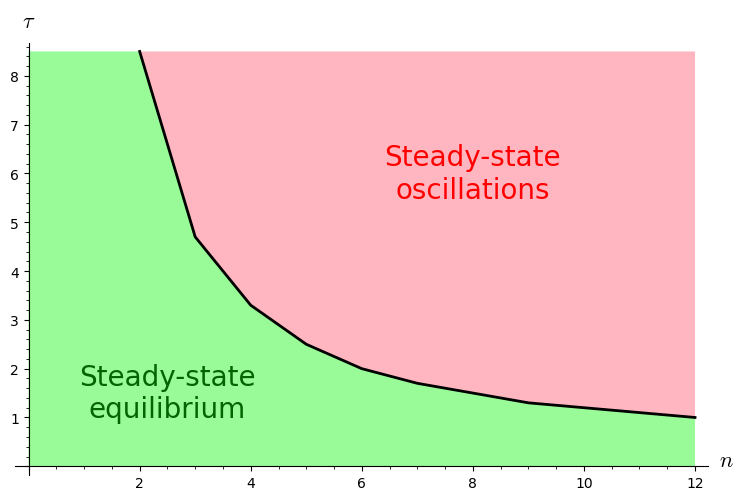

In [7]:
min_delay_for_oscillations = {
    2: 8.5, 
    3: 4.7, 
    4: 3.3, 
    5: 2.5, 
    6: 2.0, 
    7: 1.7, 
    8: 1.5, 
    9: 1.3, 
    10: 1.2, 
    11: 1.1, 
    12: 1.0, 
}

xmax = max(min_delay_for_oscillations.keys())
ymax = max(min_delay_for_oscillations.values())
vertices = sorted(list(min_delay_for_oscillations.items()))

p = list_plot(vertices, plotjoined=True, thickness=2, color="black")
p += polygon([(xmax,0), (0,0), (0,ymax)] + vertices, color="palegreen")
p += polygon([(xmax,ymax)] + vertices, color="lightpink")
p += text("Steady-state\noscillations", (8, 6), color="red", fontsize=20)
p += text("Steady-state\nequilibrium", (2.5, 1.5), color="darkgreen", fontsize=20)
p.show(aspect_ratio="auto", axes_labels=("$n$", "$\\tau$"), figsize=7.5)


**We can even eliminate both the $P$ *and* the $G$**

This gives us only a single variable, and a single differential equation. But we put in an explicit time delay on the feedback part. 

$$ H'(t) = \frac{1}{1 + H(t - \tau)^n} - 0.2H(t) $$


In [12]:
@interact(n=slider(2, 40, 1, default=12, label=r"$n$ (steepness)"),
          tau=slider(0, 3, 0.1, default=0, label=r"$\tau$ (delay)"), 
          tmax=slider([60, 120, 200, 300], default=60, label=r"$t_{max}$"))
def h_delay(n, tau, tmax):
    ymax = 3
    Hprime(H, H_tau) = 1 / (1 + H_tau^n) - 0.2*H
    delayed_vars = {H_tau: (H, tau)}
    history = 1
    solution = dde_solve(Hprime, H, delayed_vars, history, tmax, 0.01)

    p1 = list_plot(solution[:,(0,1)], plotjoined=True, color="gold", ymin=0, ymax=ymax, 
                   axes_labels=("$t$", "$H$ (GnRH)"), aspect_ratio=2/3*tmax/ymax)

    p2 = plot(1 / (1 + G^n), (G, 0, 3), thickness=2, ymin=0, ymax=1.3)
    p2 += line(((0, 1), (3, 1)), color="red", linestyle="dashed")
    p2 += text(r"$\frac{1}{1 + G^{%d}}$" % n, (2.2, 0.5), color="black", fontsize=20, 
               axes_labels=(r"$G$", ""), title="Production rate of GnRH")
    both = multi_graphics([(p1, (0, 0, 0.65, 1)), 
                           (p2, (0.75, 0.6, 0.25, 0.2))])
    both.show(figsize=9)


Interactive function <function h_delay at 0x7fc0644f53a0> with 3 widgets
  n: TransformIntSlider(value=12, des…

Hopf bifurcation diagram for the H__ model with explicit time delay

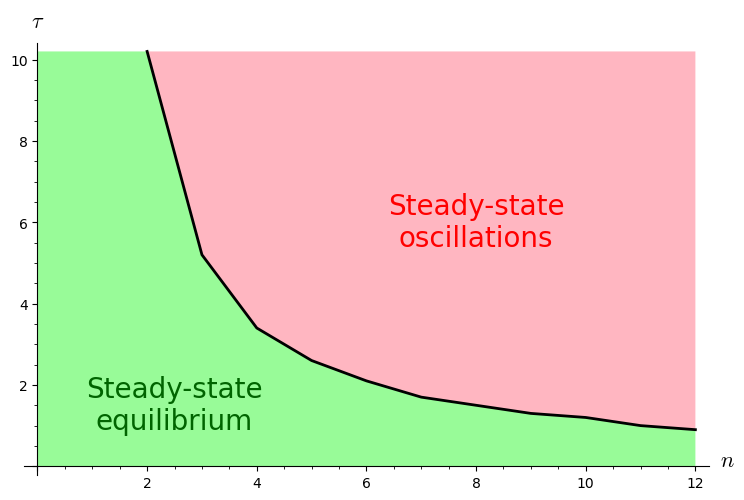

In [9]:
min_delay_for_oscillations = {
    2: 10.2, 
    3: 5.2, 
    4: 3.4, 
    5: 2.6, 
    6: 2.1, 
    7: 1.7, 
    8: 1.5, 
    9: 1.3, 
    10: 1.2, 
    11: 1.0, 
    12: 0.9, 
}

xmax = max(min_delay_for_oscillations.keys())
ymax = max(min_delay_for_oscillations.values())
vertices = sorted(list(min_delay_for_oscillations.items()))

p = list_plot(vertices, plotjoined=True, thickness=2, color="black")
p += polygon([(xmax,0), (0,0), (0,ymax)] + vertices, color="palegreen")
p += polygon([(xmax,ymax)] + vertices, color="lightpink")
p += text("Steady-state\noscillations", (8, 6), color="red", fontsize=20)
p += text("Steady-state\nequilibrium", (2.5, 1.5), color="darkgreen", fontsize=20)
p.show(aspect_ratio="auto", axes_labels=("$n$", "$\\tau$"), figsize=7.5)


In [13]:
# Add more variables for more implicit time delay

def shades_of_blue(k):
    if k == 1:
        return [(0, 0, 1)]
    colors = []
    for i in range((k + 1)//2):
        colors.append((0.5 - i/(k - 1), 0.5 - i/(k - 1), 1))
    for i in range((k + 1)//2, k):
        colors.append((0, 0, 1.5 - i/(k - 1)))
    return colors

def diagram(k):
    r = 0.15
    nodes = {}
    def node(pos, label):
        nodes[label] = vector(pos)
        p = circle(pos, r, color="black", axes=False)
        p += text("${}$".format(label), pos, color="black", fontsize=18)
        return p

    def edge(node1, node2, label, fudge=False):
        p1 = nodes[node1]
        p2 = nodes[node2]
        dir = (p2 - p1).normalized()
        p1 += r*(vector(( 0.8, -0.6)) if fudge else dir)
        p2 -= r*(vector((-0.8, -0.6)) if fudge else dir)
        p = arrow(p1, p2, color="black")
        dir = matrix(((0, -1), (1, 0))) * dir
        p += text(label, (p1 + p2)/2 + r*dir, color="black", fontsize=18)
        return p

    p = Graphics()
    dtheta = 2*pi/(k + 3)
    p += node((cos( pi - dtheta), sin( pi - dtheta)), "H")
    p += node((cos(-pi + dtheta), sin(-pi + dtheta)), "G")
    for i in range(1, k+1):
        p += node((cos(pi - (i+1)*dtheta), sin(pi - (i+1)*dtheta)), r"P_{%d}" % i)
        if i > 1:
            p += edge(r"P_{%d}" % (i-1), r"P_{%d}" % i, "$+$")
    if k == 0:
        p += edge("H", "G", "$+$", fudge=True)
    else:
        p += edge("H", r"P_{1}", "$+$")
        p += edge(r"P_{%d}" % k, "G", "$+$")
    p += edge("G", "H", "$-$")
    return p

@interact(k=slider(0, 10, 1, default=1, label="$P$ vars"), 
          n=slider(srange(1, 2, 0.1) + srange(2, 16, 1), default=2, label="$n$"), 
          tmax=slider([200, 400, 800, 2000, 4000], default=200, label=r"$t_{max}$"), 
          show_all=checkbox(True, label="Show all variables"))
def hpg_interact(k, n, tmax, show_all):
    state_vars = list(var(["H"] + ["P_{}".format(i) for i in range(1, k + 1)] + ["G"]))
    H, G = state_vars[0], state_vars[-1]
    system = [1 / (1 + G^n) - 0.2*H]
    label = r"\begin{cases} H' = \frac{1}{1 + G^{%d}} - 0.2 H \\ " % (n,)
    for i in range(1, k + 2):
        system.append(state_vars[i - 1] - 0.2*state_vars[i])
        label += r"%s' = %s - 0.2 %s \\ " % (state_vars[i], state_vars[i - 1], state_vars[i])
    label = label[:-3] + r"\end{cases}"

    J = jacobian(system, state_vars)
    G0 = find_root(G^(n+1) + G - (0.2)^-(k + 2), 0, 100000)
    J0 = matrix(RDF, J.subs(G=G0))
    stability = max([a.real() for a in J0.eigenvalues()])

    initial_state = [1] * (k + 2)
    t_range = srange(0, tmax, 0.1)
    solution = desolve_odeint(system, initial_state, t_range, state_vars)
    solution = np.insert(solution, 0, t_range, axis=1)
    ymax = solution[len(t_range)/2:,-1].max() * 1.6

    p = Graphics()
    if show_all:
        blues = shades_of_blue(k)
        p += list_plot(solution[:,(0,1)], plotjoined=True, color="gold", legend_label="$H$")
        for i in range(1, k + 1):
            p += list_plot(solution[:,(0,i + 1)], plotjoined=True, 
                           color=blues[i - 1], legend_label=r"$P_{%d}$" % i)
    p += list_plot(solution[:,(0,-1)], plotjoined=True, color="red", legend_label="$G$")
    if stability < 0:
        p += text("Stable eq", (0.5*tmax, 0.8*ymax), color="darkgreen", fontsize=18)
    else:
        p += text("Limit cycle", (0.5*tmax, 0.8*ymax), color="darkred", fontsize=18)
    p += plot(0, (x, 0, 1), thickness=0, ymin=0, ymax=ymax, 
              axes_labels=("$t$", "State vars"), aspect_ratio=0.5*tmax/ymax)

    multi_graphics([
        (p, (0, 0, 0.5, 1)), 
        (diagram(k), (0.5, 0.25, 0.5, 0.5)), 
    ]).show(figsize=10)

    if show_all:
        show(LatexExpr(label))


Interactive function <function hpg_interact at 0x7fc0647cad30> with 4 widgets
  k: TransformIntSlider(value=1,…

Hopf bifurcation diagram for the HPPP...PG model

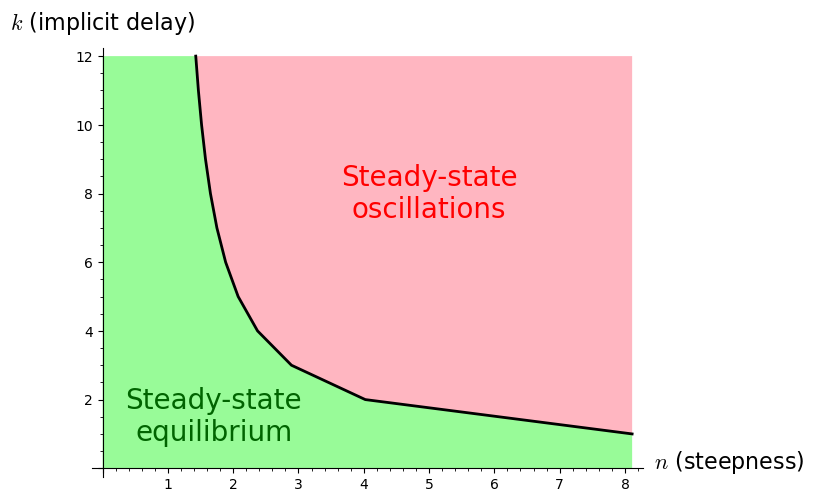

In [11]:
def minimum_n_for_oscillations(k):
    n = var("n")
    state_vars = list(var(["H"] + ["P_{}".format(i) for i in range(1, k + 1)] + ["G"]))
    H, G = state_vars[0], state_vars[-1]
    system = [1 / (1 + G^n) - 0.2*H]
    for i in range(1, k + 2):
        system.append(state_vars[i - 1] - 0.2*state_vars[i])
    J = jacobian(system, state_vars)

    def eigen_real_part(n):
        G0 = find_root(G^(n+1) + G - (0.2)^-(k + 2), 0, 100000)
        J0 = matrix(RDF, J.subs(G=G0, n=n))
        return max([a.real() for a in J0.eigenvalues()])

    try:
        return find_root(eigen_real_part, 1, 100)
    except RuntimeError:
        return Infinity

ymax = 12
k_values = range(1, ymax + 1)
n_values = [minimum_n_for_oscillations(k) for k in k_values]
xmax = max(n_values)
vertices = list(zip(n_values, k_values))

p = list_plot(vertices, plotjoined=True, thickness=2, color="black")
p += polygon([(0,ymax), (0,0), (xmax,0)] + vertices, color="palegreen")
p += polygon([(xmax,ymax)] + vertices, color="lightpink")
p += text("Steady-state\noscillations", (5, 8), color="red", fontsize=20)
p += text("Steady-state\nequilibrium", (1.7, 1.5), color="darkgreen", fontsize=20)
p.show(aspect_ratio="auto", axes_labels=("$n$ (steepness)", "$k$ (implicit delay)"), figsize=7.5)
